# Import

In [1]:
import os
import cv2 
import PIL
import glob
import pickle
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randint
from tensorflow import keras 
from skimage.color import rgb2hsv
from sklearn.cluster import KMeans
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from google.colab.patches import cv2_imshow
from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split
%matplotlib inline

# Loading QuickDraw Dataset

In [ ]:
path = "/content/drive/MyDrive/CV Project/DATA/"
files = os.listdir(path)
files.sort()

# Number of samples to be included from each category
sample_count = 20000

X = np.empty([0, 784])
Y = np.empty([0])
class_names = []
ID = 0

class_ID = {}

for file_name in files:
  data = np.load(path + file_name)[0:sample_count, :]
  sample_labels = np.full(sample_count, ID)
  class_ID[file_name[:file_name.find(".")]] = ID
  class_names.append(file_name[:file_name.find(".")])
  X = np.concatenate((X, data), axis=0)
  Y = np.append(Y, sample_labels)

  ID += 1


airplane


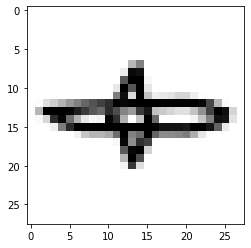

In [ ]:
idx = 50
plt.imshow(X[idx].reshape(28,28), "Greys")
print(class_names[int(Y[idx].item())])

# QuickDraw Data Pre-Processing

Training Testing split (70-30% Split)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 3)

Data reshaping

In [ ]:
image_size = 28
num_classes = len(class_names)

# Reshape and normalize
X_train = X_train.reshape(X_train.shape[0], image_size, image_size, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], image_size, image_size, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
print("X Train Shape: ", X_train)
print("X Test Shape: ", X_test)
print("Y Train Shape: ", y_train)
print("Y Test Shape: ", y_test)

# CNN Modelling

Architecture

In [ ]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),padding='same',input_shape=X_train.shape[1:], activation='relu'))
model.add(layers.Convolution2D(16, (3, 3),padding='same',input_shape=X_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))

model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(10, activation='softmax')) 

# Train model
# adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy', metrics=['top_k_categorical_accuracy'])
print(model.summary())

Training Model

In [ ]:
import time
s_t = time.time()
model.fit(x = X_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)
print("Time of execution: ", time.time() - s_t)

Saving Trained Model

In [ ]:
db = {}

# Its important to use binary mode
dbfile = open('/content/drive/MyDrive/CV Project/Model/model_30000.pkl', 'ab')

db["Model"] = model

# source, destination
pickle.dump(db, dbfile)                     
dbfile.close()

# Loading Saved Model

In [ ]:
def evaluate(testlabel, y_pred):

  from sklearn.metrics import classification_report
  print(classification_report(testlabel,y_pred))
  print()
  from sklearn.metrics import confusion_matrix
  arr = []

  from sklearn.metrics import cohen_kappa_score
  ckscore = cohen_kappa_score(testlabel, y_pred)
  print("Cohen Kappa Score: ", ckscore)
  arr.append(ckscore)


  print()
  from sklearn.metrics import matthews_corrcoef
  mcc = matthews_corrcoef(testlabel, y_pred)
  print("MCC Score: ", mcc)
  arr.append(mcc)

  print()

  from sklearn.metrics import balanced_accuracy_score
  ba = balanced_accuracy_score(testlabel, y_pred)
  print("Balanced Accuract: ",ba)
  arr.append(ba)
  return arr

In [ ]:
dbfile = open('/content/drive/MyDrive/CV Project/Model/model_20000.pkl', 'rb')     
db = pickle.load(dbfile)

model_saved = db["Model"]
dbfile.close()

# Loading Hand-Drawn Extracted Doodle Dataset

In [ ]:
doodle_path = "/content/drive/MyDrive/CV Project/npyimages2/"

doodle_files = os.listdir(doodle_path)
doodle_files.sort()

doodle_inputs = np.empty([0, 28*28])
doodle_labels = []

for doodle in doodle_files:
  label = int(doodle[0])
  image = np.load(doodle_path + doodle)
  doodle_inputs = np.concatenate((doodle_inputs, image.reshape(1,28*28)), axis=0)
  doodle_labels.append(int(doodle[0]))

doodle_inputs = doodle_inputs.reshape(doodle_inputs.shape[0], image_size, image_size, 1).astype('float32')


# CNN-Model Performance on X_Test set

In [ ]:
predictions = model_saved.predict(X_test)
predictions_labels = np.argmax(predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

score = evaluate(predictions_labels, y_test_labels)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

# CNN-Model Performance on Hand-Drawn Doodle Dataset

In [ ]:
doodle_predictions = model_saved.predict(doodle_inputs)
doodle_predictions_labels = np.argmax(doodle_predictions, axis=1)

score = evaluate(doodle_predictions_labels, doodle_labels)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

# DEMO

5_1.jpg


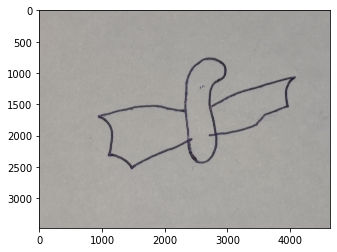

In [ ]:
pathh = "/content/drive/MyDrive/CV Project/Final Doodles/"
pathh_2 = "/content/drive/MyDrive/CV Project/"

hand_drawn_files = os.listdir(pathh)

file_num = 10
original_lbl = int(hand_drawn_files[file_num][0])
print(hand_drawn_files[file_num])
img = cv2.imread(pathh + hand_drawn_files[file_num])

# pth = "IMG_20220430_225745~2.jpg"
# img = cv2.imread(pathh_2 + pth)


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)



Image HSV Space

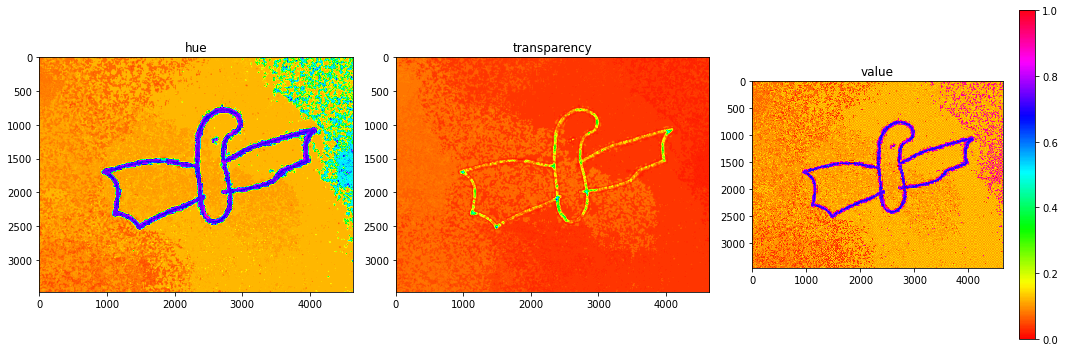

In [ ]:

bags_hsv = rgb2hsv(img)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(bags_hsv[:,:,0],cmap='hsv')
ax[0].set_title('hue')
ax[1].imshow(bags_hsv[:,:,1],cmap='hsv')
ax[1].set_title('transparency')
ax[2].imshow(bags_hsv[:,:,2],cmap='hsv')
ax[2].set_title('value')
fig.colorbar(imshow(bags_hsv[:,:,0],cmap='hsv')) 
fig.tight_layout()

Choosing between HUE and Transparency space

Choosing HUE


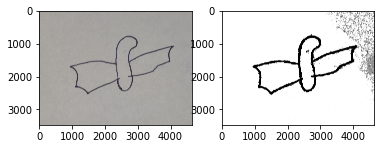

In [ ]:
gray_0 = bags_hsv[:,:,0]
gray_0 *= 255
gray_0 = np.uint8(gray_0)
otsu_threshold, image_result_0 = cv2.threshold(gray_0, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
cluster_diff_0 = np.sum(image_result_0 == 0) - np.sum(image_result_0 == 1)

gray_1 = bags_hsv[:,:,1]
gray_1 *= 255
gray_1 = np.uint8(gray_1)
otsu_threshold, image_result_1 = cv2.threshold(gray_1, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
cluster_diff_1 = np.sum(image_result_1 == 0) - np.sum(image_result_1 == 1)

ratio_threshold = 0.8
if(min(cluster_diff_0, cluster_diff_1)/max(cluster_diff_0, cluster_diff_1) < ratio_threshold):
  if(cluster_diff_0 >= cluster_diff_1):
    print("Choosing HUE")
    image_result = image_result_0
  else:
    print("Choosing transparency")
    image_result = image_result_1 
else:
  if(cluster_diff_0 <= cluster_diff_1):
    print("Choosing HUE")
    image_result = image_result_0
  else:
    print("Choosing transparency")
    image_result = image_result_1 

# 1
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img, 'Greys')
axarr[1].imshow(image_result, 'Greys')

Noise Reduction

Denoising the doodle


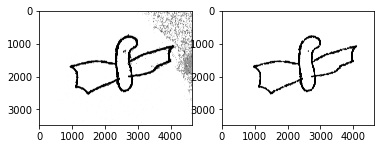

In [ ]:
black_count1 = (image_result==1).sum()
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(image_result, cv2.MORPH_OPEN, kernel, iterations=5)

black_count2 = (opening==1).sum()

if(black_count2/black_count1) < 0.5:
  kernel = np.ones((5,5),np.uint8)
  opening = cv2.morphologyEx(image_result, cv2.MORPH_OPEN, kernel, iterations=1)
  plt.imshow(opening, 'Greys')

print("Denoising the doodle")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_result, 'Greys')
axarr[1].imshow(opening, 'Greys')

Image Resizing to almost 112x112

Resizing the image down to around 112x112 pixels


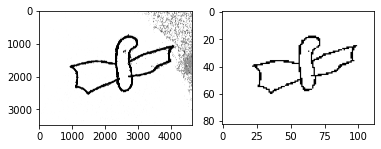

In [ ]:


base_width = 112
image = Image.fromarray(opening)
width_percent = (base_width / float(image.size[0]))
hsize = int((float(image.size[1]) * float(width_percent)))
image = image.resize((base_width, hsize), PIL.Image.ANTIALIAS)


# 2
print("Resizing the image down to around 112x112 pixels")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(opening, 'Greys')
axarr[1].imshow(image, 'Greys')

Image dilation

Dilating the 112x112 image to make the doodle thicker and easier to extract


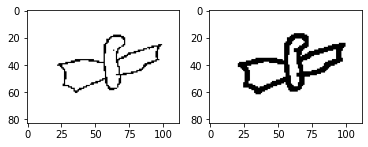

In [ ]:
kernel = np.ones((3,3), np.uint8)
img_dilation = cv2.dilate(np.array(image), kernel, iterations=1)

gray = img_dilation
gray *= 255
gray = np.uint8(gray)
otsu_threshold, image_result = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)

opening = image_result

# 3
print("Dilating the 112x112 image to make the doodle thicker and easier to extract")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image, 'Greys')
axarr[1].imshow(opening, 'Greys')

Making bounding box around the doodle

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Making a square bounding box around the doodle and cropping out the doodle


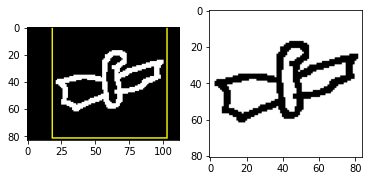

In [ ]:
min_x = opening.shape[0]
min_y = opening.shape[1]
max_x = -1
max_y = -1

color_opening = np.zeros((opening.shape[0], opening.shape[1], 3))

for i in range(opening.shape[0]):
  for j in range(opening.shape[1]):
    color_opening[i][j][:] = opening[i][j]

    if(opening[i][j]>0.5):
      if(i < min_x):
        min_x = i
      if(j < min_y):
        min_y = j
      if(i > max_x):
        max_x = i
      if(j > max_y):
        max_y = j

mid_x = int((max_x + min_x)/2)
mid_y = int((max_y + min_y)/2)

l = int(max((max_x-min_x), (max_y-min_y))/2) + 3

rect = cv2.rectangle(color_opening.copy(), (mid_y-l, mid_x-l), (mid_y+l, mid_x+l), (255,255,0), 1)

new_img = np.zeros((2*l, 2*l))

left = max(0, mid_x-l)
right = min(opening.shape[0], mid_x+l)
top = max(0, mid_y-l)
bottom = min(opening.shape[1], mid_y+l)

new_img = opening[left:right, top:bottom]

# 4
print("Making a square bounding box around the doodle and cropping out the doodle")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(rect, 'Greys')
axarr[1].imshow(new_img, 'Greys')

Resizing the image to 28x28

Final Cropped and pre-processed doodle


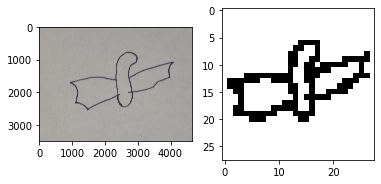

In [ ]:
base_width = 28
image = Image.fromarray(new_img)
width_percent = (base_width / float(image.size[0]))
hsize = 28
image = image.resize((base_width, hsize), PIL.Image.ANTIALIAS)
image = np.array(image)

# 5
print("Final Cropped and pre-processed doodle")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img, 'Greys')
axarr[1].imshow(image, 'Greys')

Reshaping the doodle for prediction

In [ ]:
image_size = 28
doodle_inputs = np.empty([0, 28*28])
doodle_inputs = np.concatenate((doodle_inputs, image.reshape(1,28*28)), axis=0)
doodle_inputs = doodle_inputs.reshape(doodle_inputs.shape[0], image_size, image_size, 1).astype('float32')

Getting the prediction

In [ ]:
ID_Class = {0: 'airplane', 1: 'apple', 2: 'arm', 3: 'axe', 4: 'banana', 5: 'bat', 6: 'bicycle', 7: 'bird', 8: 'bowtie', 9: 'broom'}
doodle_predictions = model_saved.predict(doodle_inputs)
doodle_predictions_labels = np.argmax(doodle_predictions, axis=1)

In [ ]:
print("Model Prediction: ", ID_Class[doodle_predictions_labels[0]])
print("Original Class: ", ID_Class[original_lbl])

Model Prediction:  bat
Original Class:  bat
